# CODE QUI DOIT FONCTIONNER

In [53]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dossier = '../data/archive/result'
hierarchical_topics = pd.read_csv(f"{dossier}/database_hierarchical_topics.csv",sep=',',encoding='utf8')
news_data = pd.read_csv(f"{dossier}/database_update.csv",sep=',',encoding='utf8')
all_topic = pd.read_csv(f"{dossier}/all_topics.csv",sep=',',encoding='utf8').iloc[1:].reset_index(drop=True)

### Pyvis

In [23]:
news_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", select_menu=True, layout=True)    
news_net.barnes_hut()
max_original_topic = hierarchical_topics.Parent_ID.astype(int).min() - 1

        # Extract mapping from ID to name
topic_to_name = dict(zip(hierarchical_topics.Child_Left_ID, hierarchical_topics.Child_Left_Name))
topic_to_name.update(dict(zip(hierarchical_topics.Child_Right_ID, hierarchical_topics.Child_Right_Name)))
topic_to_name.update(dict(zip(hierarchical_topics.Parent_ID, hierarchical_topics.Parent_Name)))

topic_to_name = {topic: name for topic, name in topic_to_name.items()}
#print((topic_to_name))
        # Create tree
tree = {row[1].Parent_ID: [row[1].Child_Left_ID, row[1].Child_Right_ID]
        for row in hierarchical_topics.iterrows()}


for parent,childs in tree.items():
        src = parent
        src_names = topic_to_name[parent]
        topic_str, distance = hierarchical_topics.loc[hierarchical_topics['Parent_ID'] == parent, ['Topics', 'Distance']].values[0]
        topics = set(int(topic.strip()) for topic in topic_str.strip('[]').split(','))
        news_net.add_node(src, src_names, title=src,size=len(topics))
        for child in childs:
                dst = child
                dst_names = topic_to_name[child]
                news_net.add_node(dst, dst_names, title=dst)
                news_net.add_edge(src, dst,values=distance)
           

for index, row in all_topic.iterrows():
        last_parent_id = None
        matching_rows = hierarchical_topics[hierarchical_topics['Topics'].apply(lambda x: row['Topic'] in list(int(topic.strip()) for topic in x.strip('[]').split(',')))]
        if not matching_rows.empty:
                last_parent_id = matching_rows['Parent_ID'].iloc[-1]
        #last_parent_ids[str(row['Topic'])]= last_parent_id
        Child_ID = hierarchical_topics.loc[hierarchical_topics['Parent_ID'] == last_parent_id,['Child_Left_ID','Child_Right_ID']].values[0]
        #print(parent,Child_Left_ID,Child_Right_ID)
        if row['Topic'] not in Child_ID:
                news_net.add_node(row['Topic'], row['Name'], title=row['Topic'])
                news_net.add_edge(last_parent_id, row['Topic'])

                
for index,row in news_data.iterrows():
        if int(row['topic']) != -1 :
                news_net.add_node(row['id'],row['title'],title=row['id'])
                news_net.add_edge(row['topic'],row['id'])
        
        
neighbor_map = news_net.get_adj_list()
for node in news_net.nodes:
# Assurez-vous que node["title"] est une chaîne de caractères
        node_title_str = node["label"]
        neighbors_str = ", ".join(str(neighbor) for neighbor in neighbor_map[node["id"]])
        # Utilisez la version chaîne de caractères de node["title"] pour la concaténation
        node["title"] = node_title_str + "\n Neighbors : [" + neighbors_str + "]"
        node["value"] = len(neighbor_map[node["id"]])


news_net.toggle_physics(True)
news_net.show_buttons(True)
news_net.inherit_edge_colors(True)
news_net.save_graph("graphs_.html")   


In [84]:
from matplotlib.colors import ListedColormap

noms_uniques = news_data['publication'].unique()
cmap_complete = plt.cm.tab20
colors = cmap_complete.colors[:len(noms_uniques)]

cmap_custom = ListedColormap(colors)
couleur_par_journal = {journal: cmap_custom.colors[i] for i, journal in enumerate(noms_uniques)}
news_data['Couleur'] = news_data['publication'].map(couleur_par_journal)


### Networkx --> Pyvis

In [101]:
news_net = nx.Graph()   
max_original_topic = hierarchical_topics.Parent_ID.astype(int).min() - 1

topic_to_name = dict(zip(hierarchical_topics.Child_Left_ID, hierarchical_topics.Child_Left_Name))
topic_to_name.update(dict(zip(hierarchical_topics.Child_Right_ID, hierarchical_topics.Child_Right_Name)))
topic_to_name.update(dict(zip(hierarchical_topics.Parent_ID, hierarchical_topics.Parent_Name)))

topic_to_name = {topic: name for topic, name in topic_to_name.items()}
tree = {row[1].Parent_ID: [row[1].Child_Left_ID, row[1].Child_Right_ID]
        for row in hierarchical_topics.iterrows()}


for parent,childs in tree.items():
        src = parent
        src_names = topic_to_name[parent]
        topic_str, distance = hierarchical_topics.loc[hierarchical_topics['Parent_ID'] == parent, ['Topics', 'Distance']].values[0]
        topics = set(int(topic.strip()) for topic in topic_str.strip('[]').split(','))
        news_net.add_node(src, name = src_names, title=src,size=len(topics), color='red')
        for child in childs:
                dst = child
                dst_names = topic_to_name[child]
                count = all_topic.loc[all_topic['Topic'] == child, ['Count']].values
                if len(count) ==0 :
                        news_net.add_node(dst, name = dst_names, title=dst, size = 1, color='blue')
                else : 
                        news_net.add_node(dst, name = dst_names, title=dst, size = count[0][0], color='blue')
                news_net.add_edge(src, dst) 
           
number_of_topic = len(news_net.nodes)
"""for index, row in all_topic.iterrows():
        last_parent_id = None
        matching_rows = hierarchical_topics[hierarchical_topics['Topics'].apply(lambda x: row['Topic'] in list(int(topic.strip()) for topic in x.strip('[]').split(',')))]
        #print(matching_rows)
        if not matching_rows.empty:
                last_parent_id = matching_rows['Parent_ID'].iloc[-1]
        Child_ID = hierarchical_topics.loc[hierarchical_topics['Parent_ID'] == last_parent_id,['Child_Left_ID','Child_Right_ID']].values[0]
        #print(f"Row : {row['Topic']} \n Child : {Child_ID}")
        if row['Topic'] not in Child_ID:
                news_net.add_node(row['Topic'], name = row['Name'], title=row['Topic'], size = 1000,color='black')
                news_net.add_edge(last_parent_id, row['Topic'])
"""
        
for index,row in news_data[:3000].iterrows():
        if int(row['topic']) != -1 :
                news_net.add_node(row['id'],name=row['title'],title=row['id'], size = 1, color=row['Couleur'])
                news_net.add_edge(row['topic'],row['id'])

        



In [102]:
news_net_pyvis = Network(height="750px", width="100%", bgcolor="white", font_color="white", select_menu=True, layout=True)
news_net_pyvis.from_nx(news_net)
news_net_pyvis.toggle_physics(True)
news_net_pyvis.show_buttons(True)
news_net_pyvis.save_graph("graphs_NX.html") 

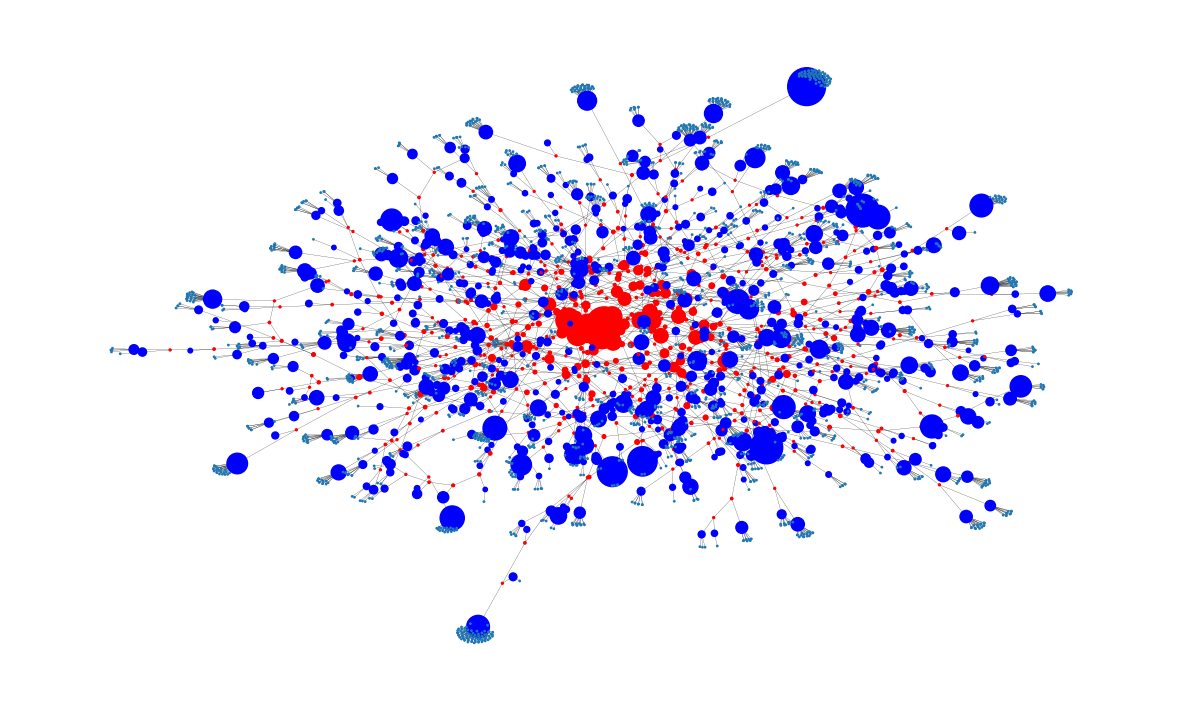

In [104]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = { "with_labels": False, "width": 0.15}
colors = [news_net.nodes[n]['color'] for n in news_net.nodes]
sizes = [news_net.nodes[n]['size'] for n in news_net.nodes]
pos = nx.spring_layout(news_net, iterations=50, dim=2)
nx.draw_networkx(news_net, node_size=sizes, node_color=colors,pos=pos, ax=ax, **plot_options)
plt.show()


### Analysis : 

## Community 

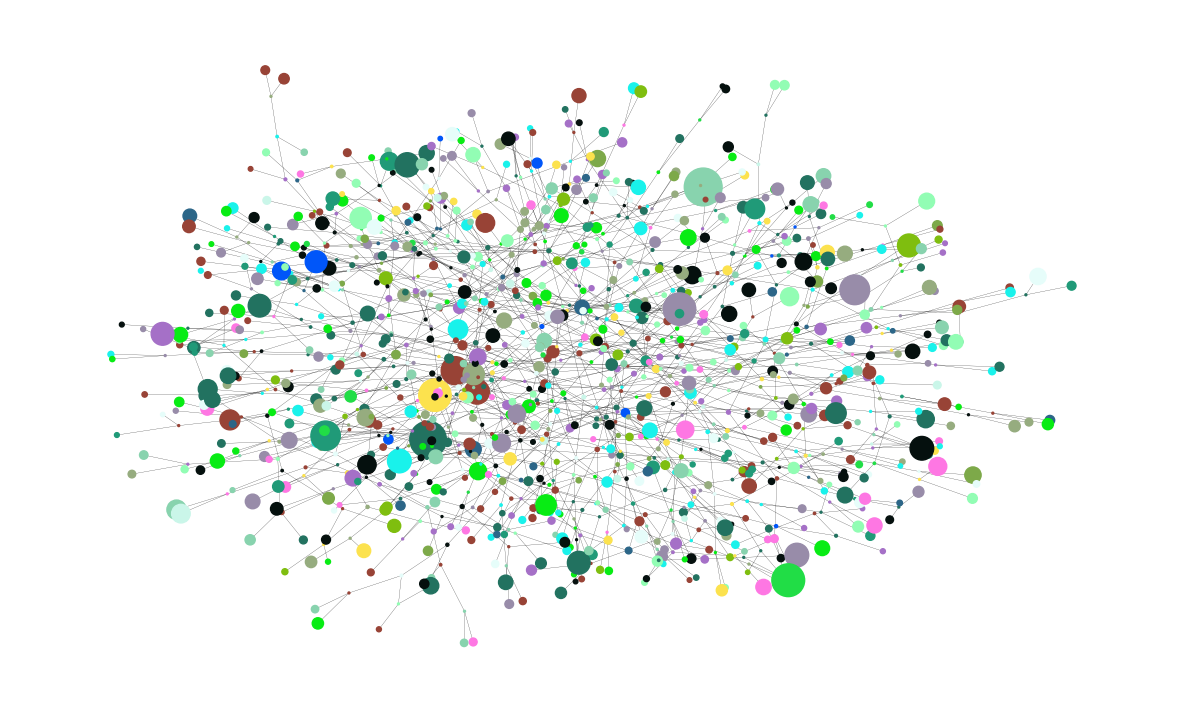

In [94]:
for com in nx.community.asyn_fluidc(news_net,number_of_topic):
    color = "#%06X" % np.random.randint(0, 0xFFFFFF)  # creates random RGB color
    for node in list(com):
        colors[node] = color

fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = { "with_labels": False, "width": 0.15}
sizes = [news_net.nodes[n]['size'] for n in news_net.nodes]
pos = nx.spring_layout(news_net, iterations=20, dim=2)
nx.draw_networkx(news_net, node_size=sizes, node_color=colors,pos=pos, ax=ax, **plot_options)
plt.show()

In [20]:
last_parent_ids = {}

for index, row in all_topic.iterrows():
    # Initialize a variable to hold the last parent_id found
    last_parent_id = None
    #print(row)
    matching_rows = hierarchical_topics[hierarchical_topics['Topics'].apply(lambda x: row['Topic'] in list(int(topic.strip()) for topic in x.strip('[]').split(',')))]
    
    # If there are matching rows, update last_parent_id with the last Parent_ID
    if not matching_rows.empty:
        last_parent_id = matching_rows['Parent_ID'].iloc[-1]  # Get the last matching parent ID
    
    # Append the last_parent_id to the list
    last_parent_ids[str(row['Topic'])]= last_parent_id

# Now last_parent_ids list contains the last parent ID for each row in all_topic
print(last_parent_ids)


{'0': 848, '1': 768, '2': 775, '3': 790, '4': 713, '5': 751, '6': 798, '7': 768, '8': 785, '9': 754, '10': 755, '11': 842, '12': 722, '13': 847, '14': 749, '15': 766, '16': 738, '17': 742, '18': 892, '19': 746, '20': 955, '21': 746, '22': 827, '23': 923, '24': 815, '25': 855, '26': 725, '27': 950, '28': 833, '29': 796, '30': 908, '31': 705, '32': 806, '33': 858, '34': 747, '35': 807, '36': 961, '37': 704, '38': 715, '39': 699, '40': 850, '41': 695, '42': 805, '43': 860, '44': 841, '45': 846, '46': 810, '47': 762, '48': 734, '49': 703, '50': 730, '51': 901, '52': 1137, '53': 869, '54': 1049, '55': 1004, '56': 792, '57': 809, '58': 820, '59': 720, '60': 874, '61': 736, '62': 771, '63': 781, '64': 813, '65': 934, '66': 1017, '67': 696, '68': 707, '69': 902, '70': 753, '71': 835, '72': 823, '73': 1012, '74': 863, '75': 721, '76': 752, '77': 865, '78': 861, '79': 815, '80': 823, '81': 724, '82': 764, '83': 701, '84': 717, '85': 816, '86': 981, '87': 722, '88': 862, '89': 948, '90': 804, '91

# Tree test

In [44]:
max_distance = None
width = 1 
hier_topics = pd.read_csv(f"archive/test/result/database_hierarchical_topics.csv")
if max_distance is None:
    max_distance = hier_topics.Distance.max() + 1

max_original_topic = hier_topics.Parent_ID.astype(int).min() - 1

# Extract mapping from ID to name
topic_to_name = dict(zip(hier_topics.Child_Left_ID, hier_topics.Child_Left_Name))
topic_to_name.update(dict(zip(hier_topics.Child_Right_ID, hier_topics.Child_Right_Name)))
topic_to_name = {str(topic): name[:100] for topic, name in topic_to_name.items()}

# Create tree
tree = {str(row[1].Parent_ID): [str(row[1].Child_Left_ID), str(row[1].Child_Right_ID)]
        for row in hier_topics.iterrows()}

def get_tree(start, tree):
    """ Based on: https://stackoverflow.com/a/51920869/10532563 """

    def _tree(to_print, start, parent, tree, grandpa=None, indent=""):

        # Get distance between merged topics
        distance = hier_topics.loc[(hier_topics.Child_Left_ID == parent) |
                                    (hier_topics.Child_Right_ID == parent), "Distance"]
        distance = distance.values[0] if len(distance) > 0 else 10

        if parent != start:
            if grandpa is None:
                to_print += topic_to_name[parent]
            else:
                if int(parent) <= max_original_topic:
                    to_print += "■──" + topic_to_name[parent] + f" ── Topic: {parent}" + "\n"
                    
                else:
                    to_print += topic_to_name[parent] + "\n"

        if parent not in tree:
            return to_print

        for child in tree[parent][:-1]:
            to_print += indent + "├" + "─"
            to_print = _tree(to_print, start, child, tree, parent, indent + "│" + " " * width)

        child = tree[parent][-1]
        to_print += indent + "└" + "─"
        to_print = _tree(to_print, start, child, tree, parent, indent + " " * (width+1))

        return to_print

    to_print = "." + "\n"
    to_print = _tree(to_print, start, start, tree)
    return to_print

start = str(hier_topics.Parent_ID.astype(int).max())
print(get_tree(start, tree))

FileNotFoundError: [Errno 2] No such file or directory: 'archive/test/result/database_hierarchical_topics.csv'

In [6]:
import pandas as pd

df = pd.read_csv(f"../data/archive/database_merge.csv")
key_to_check = 7174
print(df[7170:7180])
print(df.index[7170:7180])
if key_to_check in df.index:
    # Proceed with operations on 
    print("Key exists!")
else:
    print("Key does not exist in the DataFrame index.")


           id                                              title  \
7170  25698.0  Without Obama, Shinzo Abe’s Approach to U.S.-J...   
7171  25700.0  Giving Up ‘Mostly Everything’ to Care for His ...   
7172  25701.0  Carrie Fisher, Trump, Israel: Your Wednesday E...   
7173  25703.0  How to Have a Dinner Party: Friends Not Requir...   
7174  25704.0                   The Fighter - The New York Times   
7175  25705.0  A Brother’s Crimes and a Sister’s Betrayal Mak...   
7176  25708.0  Uncertainty Over New Chinese Law Rattles Forei...   
7177  25709.0  A Majority Agreed She Was Raped by a Stanford ...   
7178  25710.0  Searching for the Human Factor in Deadly Avala...   
7179  25713.0  Michael Skakel’s Murder Conviction Has Been Re...   

         publication                             author        date    year  \
7170  New York Times                        Motoko Rich  2017-01-05  2017.0   
7171  New York Times                          John Otis  2016-12-29  2016.0   
7172  New York

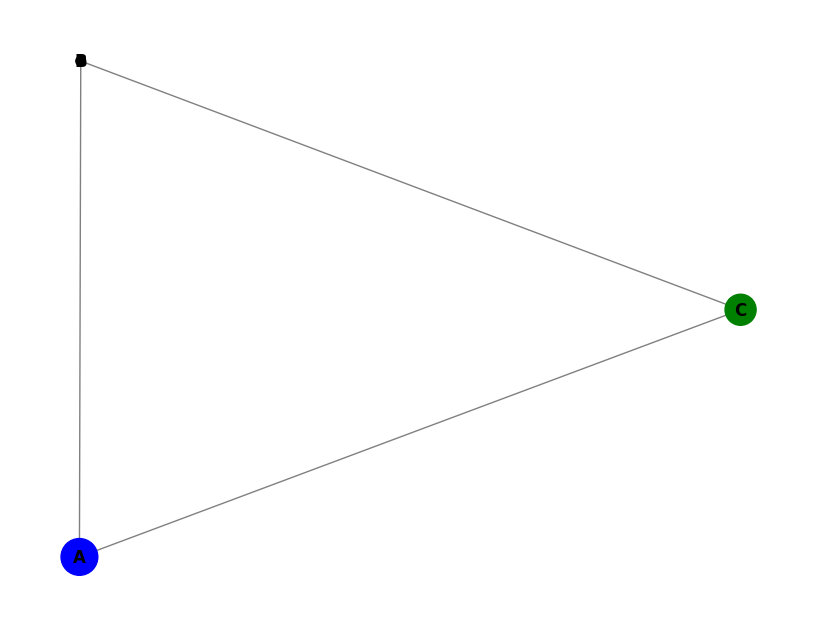

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# Créer un graphique
G = nx.Graph()

# Ajouter des nœuds avec des attributs de couleur et de taille
G.add_node('A', color='blue', size=700)
G.add_node('B', color='red', size=1000)
G.add_node('B', color='black', size=50)
G.add_node('C', color='green', size=500)

# Ajouter des arêtes entre les nœuds
G.add_edge('A', 'B')
G.add_edge('A', 'C')
G.add_edge('B', 'C')

# Préparer les couleurs et les tailles pour le dessin
colors = [G.nodes[n]['color'] for n in G.nodes]
sizes = [G.nodes[n]['size'] for n in G.nodes]

# Dessiner le graphique
plt.figure(figsize=(8, 6))
nx.draw(G, node_color=colors, node_size=sizes, with_labels=True, font_weight='bold', edge_color='gray')
plt.show()
